<a href="https://colab.research.google.com/github/DarrenHuangTW/od_rag_knowledge_share/blob/main/OD_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embeddings & RAG: Understanding AI Beyond ChatGPT

## Two Types of AI Models

**Generative Models** (like ChatGPT): Text input → Generate new text output  
**Embedding Models** (like BERT): Text input → Generate numeric representations (vectors)

![Generative vs Embedding Models](https://raw.githubusercontent.com/DarrenHuangTW/overdose-rag/refs/heads/master/static/embedding%20vs%20generative%20models.jpg)

### Key Insight for SEO
- **BERT** (Google's 2019 breakthrough) = Embedding model
- Converts queries and web pages into mathematical vectors
- Enables semantic similarity understanding

### Today's Exploration
1. **Vectorization** - Convert text to numbers
2. **Visualization** - See language relationships in space
3. **Similarity** - Measure concept relationships  
4. **RAG** - Build intelligent search systems

In [2]:
!pip install -q chromadb
!pip install -q plotly
%matplotlib inline

In [4]:
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio
from matplotlib.colors import TwoSlopeNorm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from openai import OpenAI
import pandas as pd
import numpy as np
import math
import chromadb
import os
import getpass
import requests

ModuleNotFoundError: No module named 'sklearn'

## From Text to Numbers: How AI "Sees" Language

Before AI can understand text, it must convert words into mathematical coordinates. This transformation is the foundation of how modern search engines like Google understand meaning beyond exact keyword matches.

**The Magic**: Words with similar meanings end up with similar coordinates in mathematical space.

![Vector Embeddings Example](https://raw.githubusercontent.com/DarrenHuangTW/overdose-rag/refs/heads/master/static/vectorization%20example.png)

**What you're seeing above:**
- People words (blue) cluster together: king, man, woman
- Food words (red) cluster together: apple, banana, orange  
- Sports words (green) cluster together: football, golf, tennis
- Each word becomes a precise mathematical point, but similar concepts naturally group together

In [ ]:
api_key = getpass.getpass('Please enter your OpenAI API key: ')
os.environ["OPENAI_API_KEY"] = api_key

Please enter your OpenAI API key: ··········


In [ ]:
# Initialize OpenAI client
client = OpenAI()
model = "text-embedding-3-small"

def get_openai_embedding(text):
    """Get embedding for a given text using OpenAI's API."""
    embedding = client.embeddings.create(input=[text], model=model).data[0].embedding
    return embedding

In [ ]:
text = "cat"
embedding = get_openai_embedding(text)

print(f"--- Embedding for {text} ---")
print(embedding[:20], "... 1,516 More Values")
print("\n--- Length ---")
print(len(embedding), "Dimensions")

--- Embedding for cat ---
[0.025523457676172256, -0.02345273084938526, -0.01607721857726574, 0.039367083460092545, 0.02103300392627716, -0.026314521208405495, 0.0018526028143242002, 0.030642108991742134, -0.015949252992868423, 0.0053222342394292355, 0.022173067554831505, -0.000238300854107365, 0.01040598563849926, 0.00310899899341166, 0.029851045459508896, 0.006305248010903597, -0.021416902542114258, -0.010731718502938747, -0.030525775626301765, 0.05751502886414528] ... 1,516 More Values

--- Length ---
1536 Dimensions


In [ ]:
# from google.colab import files
# uploaded = files.upload()

# 100_words.csv: https://drive.google.com/file/d/1TMkjvD3UkmCGmTF6nT1FBY3C5HnM7zbB/view
# 100_embeddings.csv: https://drive.google.com/file/d/1VmyyKrkWS_OG1BG5odC9-cxO5i57FGQ_/view

animal_embeddings= 'https://drive.google.com/uc?export=download&id=1VmyyKrkWS_OG1BG5odC9-cxO5i57FGQ_'
df = pd.read_csv(animal_embeddings)
print(df.head())

       Word Category                                          embedding
0       dog   Animal  [0.05112519487738609, -0.018667098134756088, -...
1       cat   Animal  [0.02554909884929657, -0.023443276062607765, -...
2  elephant   Animal  [0.04685530066490173, -0.03673475980758667, -0...
3      lion   Animal  [0.033092185854911804, -0.06823699176311493, 0...
4     tiger   Animal  [-0.02248244918882847, -0.044790614396333694, ...


# VISUALIZATION

### 2D

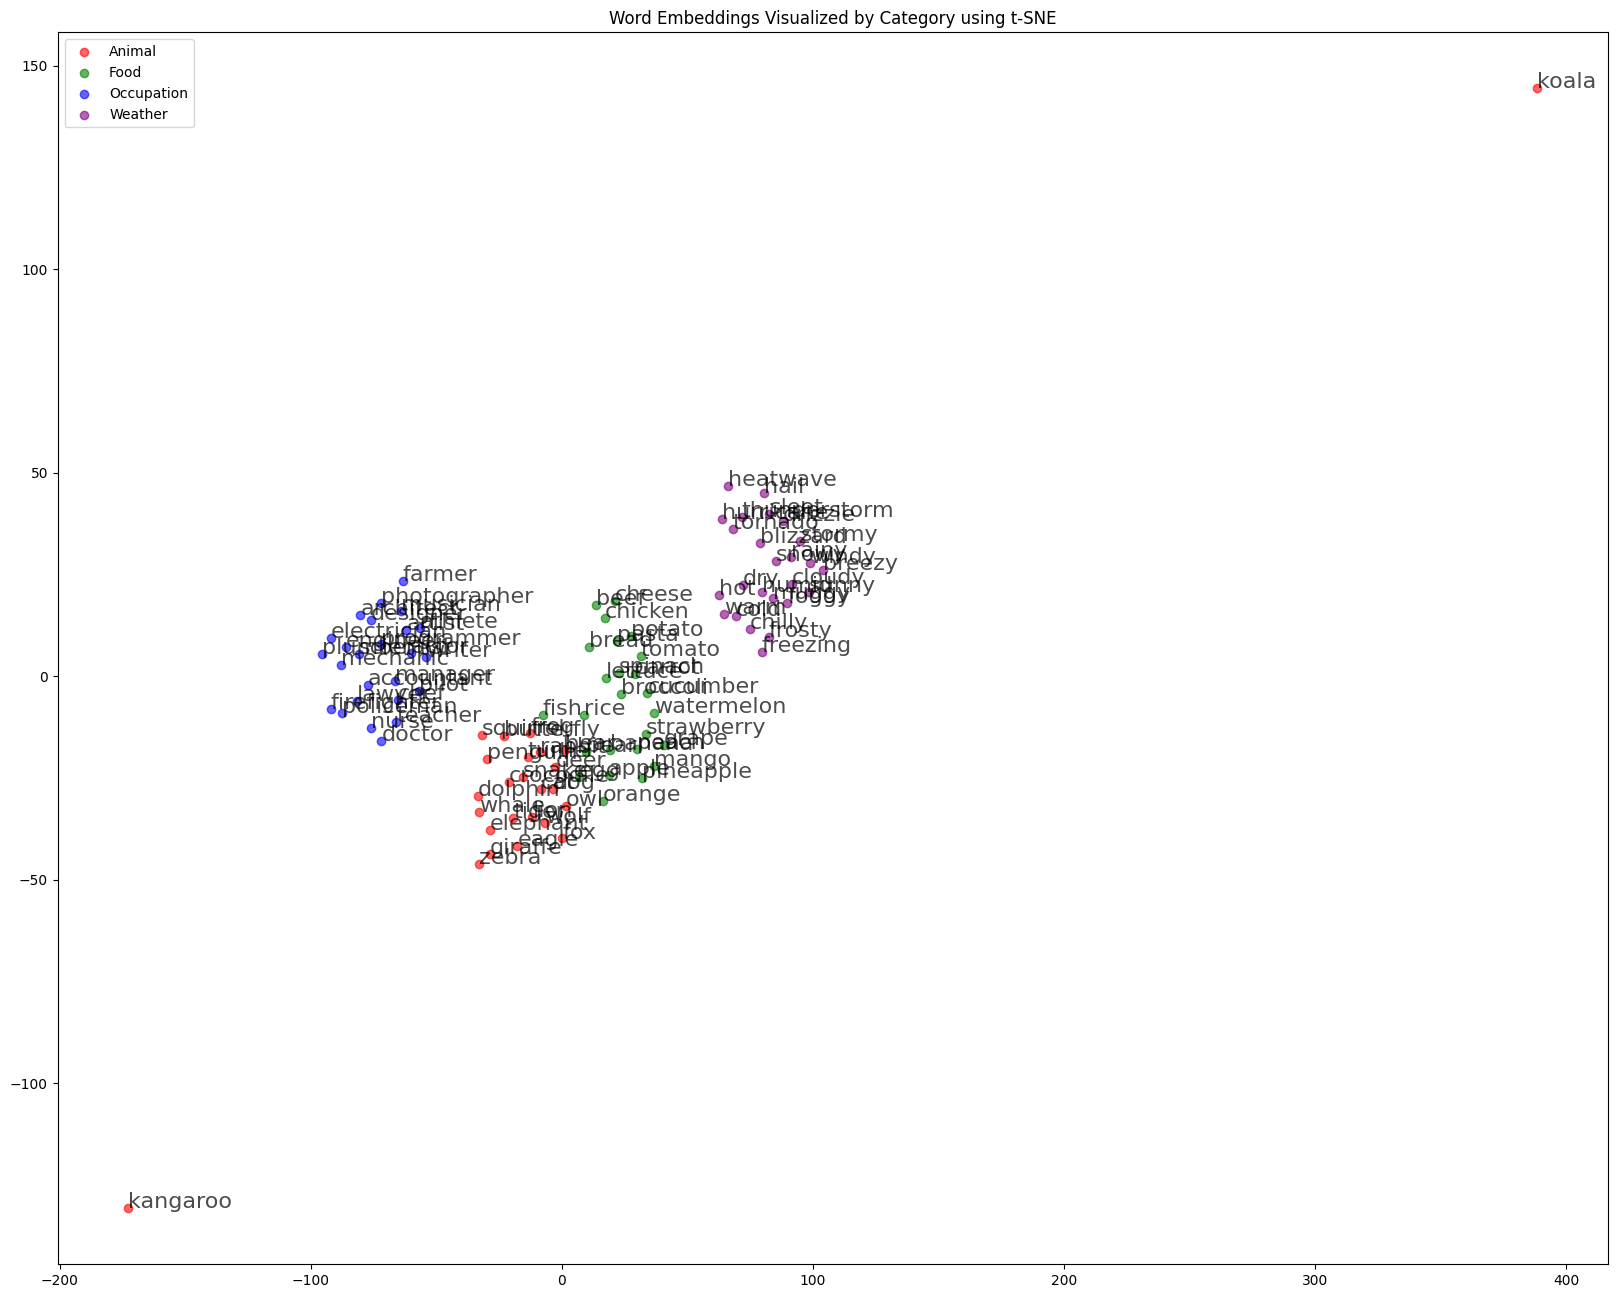

In [ ]:
# Convert string representations of lists to numpy arrays
matrix = np.array(df['embedding'].apply(eval).tolist())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=2, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

# Define colors for each category
category_colors = {
    'Animal': 'red',
    'Food': 'green',
    'Occupation': 'blue',
    'Weather': 'purple'
}

# Create the scatter plot
plt.figure(figsize=(20, 16))  # Increased figure size for better visibility
for category, color in category_colors.items():
    category_mask = df['Category'] == category
    category_data = vis_dims[category_mask]
    words = df['Word'][category_mask]

    plt.scatter(category_data[:, 0], category_data[:, 1], c=color, label=category, alpha=0.6)

    # Add labels to each point
    for i, word in enumerate(words):
        plt.annotate(word, (category_data[i, 0], category_data[i, 1]), fontsize=16, alpha=0.7)

plt.title("Word Embeddings Visualized by Category using t-SNE")
plt.legend()
plt.show()

### 3D

In [ ]:
# Convert string representations of lists to numpy arrays
matrix = np.array(df['embedding'].apply(eval).tolist())

# Create a t-SNE model and transform the data
tsne = TSNE(
    n_components=3,
    perplexity=10,
    max_iter=5000,
    learning_rate='auto',
    init='pca',
    random_state=2
)
vis_dims = tsne.fit_transform(matrix)

category_colors = {
    'Animal': 'red',
    'Food': 'green',
    'Occupation': 'blue',
    'Weather': 'purple'
}

# Create traces for each category
traces = []
for category, color in category_colors.items():
    category_mask = df['Category'] == category
    category_data = vis_dims[category_mask]
    words = df['Word'][category_mask]

    # Create hover text with only coordinates
    hovertext = [f"X: {x:.2f}, Y: {y:.2f}, Z: {z:.2f}"
                 for x, y, z in category_data]

    trace = go.Scatter3d(
        x=category_data[:, 0],
        y=category_data[:, 1],
        z=category_data[:, 2],
        mode='markers+text',
        name=category,
        marker=dict(
            size=5,
            color=color,
            opacity=0.7
        ),
        text=words,
        textposition="top center",
        hovertext=hovertext,
        hoverinfo='text',
        textfont=dict(size=12)
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title="Word Embeddings Visualized by Category using t-SNE (3D)",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube',
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
    ),
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=0.9,
        y=0.9,
        traceorder="normal",
        font=dict(size=12),
        bgcolor="rgba(255, 255, 255, 0.5)"
    ),
    hovermode='closest'
)

# Create the figure and display
fig = go.Figure(data=traces, layout=layout)
# init_notebook_mode(connected=True)
fig.show()

## Measuring Similarity: How AI Understands Relationships

Once we have words as vectors, we can measure how "close" they are to each other in mathematical space. This is how AI systems understand that some concepts are more related than others.

### The Famous King-Queen Example

![King Queen Vector Math](https://raw.githubusercontent.com/DarrenHuangTW/overdose-rag/refs/heads/master/static/king%20queen.png)

**The magic of vector arithmetic**: `king - man + woman ≈ queen`

This shows that embeddings capture semantic relationships - the "royalty" concept transfers across gender.

### How Similarity is Calculated

![Cosine Similarity](https://raw.githubusercontent.com/DarrenHuangTW/overdose-rag/refs/heads/master/static/cosine%20similarity.png)

**Cosine similarity** measures the angle between vectors:
- **Smaller angle = Higher similarity** (closer to 1.0)
- **Larger angle = Lower similarity** (closer to 0.0)
- Similar concepts point in similar directions in vector space

In [ ]:
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors."""
    dot_prod = sum(a * b for a, b in zip(vec1, vec2))
    mag1 = math.sqrt(sum(a ** 2 for a in vec1))
    mag2 = math.sqrt(sum(b ** 2 for b in vec2))
    return dot_prod / (mag1 * mag2) if mag1 * mag2 != 0 else 0

In [ ]:
word1 = "koala"
word2 = "kangaroo"

vec1 = get_openai_embedding(word1)
vec2 = get_openai_embedding(word2)

print(f"--- Embedding for '{word1}': {vec1[:5]}... total 1,536 Values")
print(f"--- Embedding for '{word2}': {vec2[:5]}... total 1,536 Values")

print(f"\nSimilarity Score of '{word1}' & '{word2}': ", cosine_similarity(vec1, vec2))

--- Embedding for 'koala': [0.0009003536542877555, -0.015921324491500854, -0.02186109870672226, -0.0027241031639277935, -0.0017785185482352972]... total 1,536 Values
--- Embedding for 'kangaroo': [-0.024211866781115532, -0.005289626307785511, -0.0193809624761343, 0.018793225288391113, -0.03423205390572548]... total 1,536 Values

Similarity Score of 'koala' & 'kangaroo':  0.647965997321589


In [ ]:
word1 = "what is SEO"
word2 = "SEO, or Search Engine Optimization, is the practice of enhancing a website's visibility and ranking on search engine results pages (SERPs) to increase organic traffic."

vec1 = get_openai_embedding(word1)
vec2 = get_openai_embedding(word2)

print(f"--- Embedding for '{word1}': {vec1[:5]}... total 1,536 Values")
print(f"--- Embedding for '{word2}': {vec2[:5]}... total 1,536 Values")

print(f"\nSimilarity Score of '{word1}' & '{word2}': ", cosine_similarity(vec1, vec2))

--- Embedding for 'what is SEO': [-0.019421231001615524, 0.0035674762912094593, -0.055858928710222244, -0.006866400130093098, 0.0089049581438303]... total 1,536 Values
--- Embedding for 'SEO, or Search Engine Optimization, is the practice of enhancing a website's visibility and ranking on search engine results pages (SERPs) to increase organic traffic.': [-0.0010451057460159063, -0.008759474381804466, -0.02063550055027008, 0.003610953688621521, 0.03994569182395935]... total 1,536 Values

Similarity Score of 'what is SEO' & 'SEO, or Search Engine Optimization, is the practice of enhancing a website's visibility and ranking on search engine results pages (SERPs) to increase organic traffic.':  0.7725305866832654


## From Words to Everything: Embeddings at Scale

Embeddings don't just work for single words. They can convert entire sentences, paragraphs, documents, and even images into mathematical vectors. This is where the real power emerges for content understanding.

### The Universal Language of Vectors

**What can be embedded:**
- ✅ Single words: "cat", "dog" 
- ✅ Sentences: "What are the health benefits of meditation?"
- ✅ Paragraphs: Full content sections
- ✅ Documents: Entire articles or web pages
- ✅ Images: Visual content understanding
- ✅ Audio: Speech and music analysis

**The key insight**: No matter the input type or length, everything becomes a vector in the same mathematical space, making comparison possible across different content types.

### Practical Demonstration: Query vs Document Ranking

Let's see how a question finds the most relevant answers from multiple documents, even when they don't share exact keywords:

In [ ]:
query = "What are the health benefits of meditation?"

documents = [
    "Several clinical studies have shown that regular meditation can help reduce stress and anxiety levels.",
    "Meditation involves focusing the mind and eliminating distractions, often through breathing techniques or guided imagery.",
    "A daily meditation practice has been associated with lower blood pressure and improved sleep quality in adults.",
    "The city of Kyoto is famous for its Zen temples, where meditation has been practiced for centuries.",
    "People who meditate frequently often report feeling calmer and more focused throughout the day.",
    "Research suggests meditation may lower the risk of heart disease by reducing inflammation and improving heart rate variability.",
    "Meditation apps have become increasingly popular, offering guided sessions on mindfulness and relaxation.",
    "A 2021 meta-analysis found that meditation can reduce symptoms of depression when used alongside other treatments.",
    "Some forms of meditation emphasize compassion and kindness, aiming to improve emotional well-being.",
    "Athletes sometimes use meditation techniques to enhance concentration and mental resilience during competition."
]

In [ ]:
# Compute embedding for the query
query_embedding = get_openai_embedding(query)

# Compute similarity scores for each document
scores = []
for doc in documents:
    doc_embedding = get_openai_embedding(doc)
    score = cosine_similarity(query_embedding, doc_embedding)
    scores.append((doc, score))

# Sort documents by similarity score (descending)
ranked = sorted(scores, key=lambda x: x[1], reverse=True)

# Print ranked documents and their scores
print(f"Query: {query}\n\n")
for i, (doc, score) in enumerate(ranked, 1):
    print(f"{i}. Score: {score:.4f}\n   {doc}\n")

Query: What are the health benefits of meditation?


1. Score: 0.5727
   Some forms of meditation emphasize compassion and kindness, aiming to improve emotional well-being.

2. Score: 0.5693
   A daily meditation practice has been associated with lower blood pressure and improved sleep quality in adults.

3. Score: 0.5641
   Research suggests meditation may lower the risk of heart disease by reducing inflammation and improving heart rate variability.

4. Score: 0.5608
   People who meditate frequently often report feeling calmer and more focused throughout the day.

5. Score: 0.5486
   Several clinical studies have shown that regular meditation can help reduce stress and anxiety levels.

6. Score: 0.4975
   A 2021 meta-analysis found that meditation can reduce symptoms of depression when used alongside other treatments.

7. Score: 0.4954
   Meditation involves focusing the mind and eliminating distractions, often through breathing techniques or guided imagery.

8. Score: 0.4669
   Medi

## Breaking Down Large Content: The Need for Chunking

Just like generative models (ChatGPT) have maximum context windows, embedding models also have limits on how much text they can process at once. When we want to embed large documents, we need to break them into smaller, manageable pieces called "chunks."

### Why Chunking is Necessary

**The problem**: 
- Embedding models have token limits (just like ChatGPT's context window)
- Large documents exceed these limits
- We need to preserve meaning while staying within constraints

**The solution**: Break documents into chunks that fit within the model's capacity

![Chunking Process](https://raw.githubusercontent.com/DarrenHuangTW/overdose-rag/refs/heads/master/static/chunk_embedding.png)

### The Chunking Process

1. **Documents** → Split into manageable text chunks
2. **Each chunk** → Converted to embedding vector 
3. **All vectors** → Stored in searchable vector database

**Key considerations:**
- **Chunk size**: Balance between context and model limits
- **Overlap**: Ensure important information isn't lost at boundaries
- **Semantic boundaries**: Try to break at natural content divisions

In [ ]:
def chunk_text(document, chunk_size):
    chunks = []
    stride = chunk_size
    current_idx = 0

    while current_idx < len(document):
        # Take chunk_size characters starting from current_idx
        chunk = document[current_idx:current_idx + chunk_size]
        if not chunk:  # Break if we're out of text
            break
        chunks.append(chunk)
        current_idx += stride  # Move forward by stride

    return chunks

In [ ]:
# quality_rater_pdf: https://services.google.com/fh/files/misc/hsw-sqrg.pdf

# Download Quality Rater Guidelines
quality_rater_doc = "https://drive.google.com/uc?export=download&id=1lObhCLp_XBmrCrV2ilXRIKgYLvLclp4k"
response = requests.get(quality_rater_doc)
document = response.text

# Chunk the document
chunks = chunk_text(document, chunk_size=600)


In [ ]:
print("\nNumber of Chunks:", len(chunks))
print("\n", "="*50, "1st Chunk", "="*50,"\n", chunks[0])
print("\n", "="*50, "2nd Chunk", "="*50,"\n", chunks[1])
print("\n", "="*50, "Last Chunk", "="*50,"\n", chunks[-1])


Number of Chunks: 33

 ================================================== 1st Chunk ================================================== 
 Introduction

Section 01	How Search Works

Section 02	Improving Search
Section 03	The Search Quality Rating Process Section 04	Summary

November 2023

Search engines exist to help people find helpful, relevant, and reliable information. To do that, search engines must provide a diverse set of high quality search results, presented in the most helpful way.
At Google, we like to say that Search is not a solved problem: We're constantly making improvements to make Search work better for our users. We put all proposed improvements to our Search product through a rigorous evaluation proce

 ================================================== 2nd Chunk ================================================== 
 ss. This process includes soliciting feedback from "Search Quality Raters", who help us measure how people are likely to experience our results.
In this do

In [ ]:
# Creating Vector Database
client = chromadb.PersistentClient()
collection = client.get_or_create_collection(name="quality_rater", metadata={"hnsw:space": "cosine"})

i = 0
for chunk in chunks:
    collection.add(
    documents=[chunk],
    ids=[f"chunk_{i}"]
    )
    i += 1

print(f"Created {collection.count()} chunks")

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:01<00:00, 81.8MiB/s]


Created 33 chunks


## RAG: How Modern AI Systems Actually Work

Now we combine everything: embeddings + chunking + similarity search + generative AI. This is **Retrieval-Augmented Generation (RAG)** - the architecture powering most AI tools you use daily.

![RAG Pipeline](https://raw.githubusercontent.com/DarrenHuangTW/overdose-rag/refs/heads/master/static/rag.png)

### The Secret Behind AI Assistants

**Popular RAG-powered tools you might recognize:**
- **NotebookLM**: Analyzes your documents and answers questions about them
- **Glean**: Enterprise search that understands context across company knowledge
- **ChatGPT with file uploads**: When you upload PDFs and ask questions
- **Perplexity**: Real-time web search + AI answers
- **Claude with documents**: This conversation right now!

### The Complete Pipeline

**Left Side (Data Preparation):**
- A → B: Raw data sources → Information extraction 
- B → C: Extract content → Break into chunks
- C → D: Convert chunks → Embed as vectors → Store in database

**Right Side (Query Flow):**
1. User asks question → Convert to embedding
2. Search vector database for similar content  
3. Retrieve most relevant chunks
4. Feed chunks + query to generative AI (LLM)
5. AI generates contextual answer

### Why RAG is Everywhere

**The problem RAG solves**: Generative AI models are trained on old data and can hallucinate. RAG gives them fresh, relevant, and verified information to work with.

**The result**: AI that can answer questions about YOUR specific content, not just general knowledge.

Let's see this in action with real Google Quality Rater Guidelines:

In [ ]:
query = "how many Search Quality Raters are there?"

results = collection.query(
    query_texts=[query],
    n_results=3)

In [ ]:
for i in range(3):
    print("-------\n")
    print("Retrieved Doc: ", i+1)
    print("Chunk: ", results['ids'][0][i])
    print("Similarity: ", 1 - results['distances'][0][i])
    print("Text Snippet: ", f"{results['documents'][0][i][:500]}...")

-------

Retrieved Doc:  1
Chunk:  chunk_9
Similarity:  0.7538037300109863
Text Snippet:  at the changes that we make are increasing the relevance and usefulness of our results for everyone.

The Search Quality Rating Process

Our Search Quality Rating Process measures the quality of Search results on an ongoing basis. We work with ~16,000 external Search Quality Raters who provide ratings based on our guidelines and represent real users and their likely information needs, using their best judgment to represent their locale.
To assess the quality of search results, Raters work f...
-------

Retrieved Doc:  2
Chunk:  chunk_7
Similarity:  0.7069815397262573
Text Snippet:  ide information that people searching find relevant and reliable as intended, we solicit feedback on proposed improvements from Search Quality Raters who use our guidelines to review the changes. These Search Quality Raters are from different locales around the globe who collectively perform millions of sample searches 

In [ ]:
# Complete the RAG Pipeline: Generate Answer

# Combine the top 3 retrieved chunks as context
context = "\n\n".join([doc for doc in results['documents'][0][:3]])

# Create the prompt for the LLM
system_prompt = """You are a helpful assistant. Use the provided context to answer the user's question. 
If the answer is not in the context, say so. Be concise and accurate."""

user_prompt = f"""Context:
{context}

Question: {query}

Please provide a clear, concise answer based on the context provided."""

# Send to OpenAI (using gpt-3.5-turbo for cost efficiency)
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ],
    max_tokens=300,
    temperature=0.1
)

print("="*60)
print("🤖 RAG-GENERATED ANSWER")
print("="*60)
print(f"Question: {query}")
print("-"*60)
print(f"Answer: {response.choices[0].message.content}")
print("="*60)

# DISCUSSION

HTML, Markdown, PDF, Word, Text, CSV, image, video, audio

Different chunking strategies

embedding models >> multilingual, multi-modality, domain-specific

where to store the data

similarity search >> how to be efficient

query transformation / contextualization

